### Loading Libraries

In [1]:
# import classes here
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

#Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

C:\Users\Ajay\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Loading data

In [2]:
# Read the data
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

PassengerId = test['PassengerId']

In [3]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Generating features

In [4]:
full_data = [train, test]

print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean(), '\n')

print (train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean(), '\n')

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# whether a passenger had a cabin
#train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
#test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
#print (train[['Has_Cabin', 'Survived']].groupby(['Has_Cabin'], as_index=False).mean(), '\n')

#Creating new feature : FamilySize
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean(), '\n')

#Creating new feature : IsAlone
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean(), '\n')
    
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean(), '\n')
    
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean(), '\n')

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)
print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean(), '\n')

#function to extract passengers names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

#Creating new feature : Title
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
print(pd.crosstab(train['Title'], train['Sex']), '\n')

#Grouping all non common titles
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean(), '\n')
    
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    # Mapping Titles
    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] >  31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[dataset.Age <= 16, 'Age'] = 0
    dataset.loc[(dataset.Age > 16) & (dataset.Age <= 32), 'Age'] = 1
    dataset.loc[(dataset.Age > 32) & (dataset.Age <= 48), 'Age'] = 2
    dataset.loc[(dataset.Age > 48) & (dataset.Age <= 64), 'Age'] = 3
    dataset.loc[dataset.Age > 64, 'Age'] = 4

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363 

      Sex  Survived
0  female  0.742038
1    male  0.188908 

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000 

   IsAlone  Survived
0        0  0.505650
1        1  0.303538 

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009 

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081 

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.495652
1   (16.0, 32.0]  0.350333
2   (32.0, 48.0]  0.391837
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909 

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr            

In [5]:
print(train.head(3), '\n')
print(test.head(3), '\n')

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name  Sex  Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1    1      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0    2      1      0   
2                             Heikkinen, Miss. Laina    0    1      0      0   

             Ticket  Fare Cabin  Embarked  Name_length  FamilySize  IsAlone  \
0         A/5 21171     0   NaN         0           23           2        0   
1          PC 17599     3   C85         1           51           2        0   
2  STON/O2. 3101282     1   NaN         0           22           1        1   

   CategoricalFare CategoricalAge  Title  
0   (-0.001, 7.91]   (16.0, 32.0]    1.0  
1  (31.0, 512.329]   (32.0, 48.0]    3.0  
2   (7.91, 14.454]   (16.0, 32.0]    2.0   

   PassengerId  Pclass                     

In [6]:
# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Name_length']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalFare', 'CategoricalAge'], axis=1)
test = test.drop(drop_elements, axis=1)

In [7]:
train.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,2,0,1.0
1,1,1,0,2,3,1,2,0,3.0
2,1,3,0,1,1,0,1,1,2.0


### Classifiers Comparison

### Visualisations

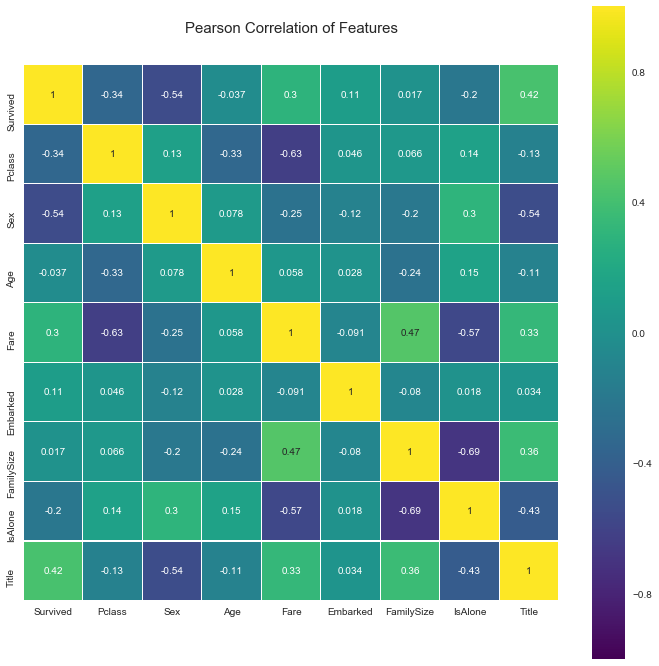

In [8]:
# Pearson Correlation Heatmap
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Pairplots

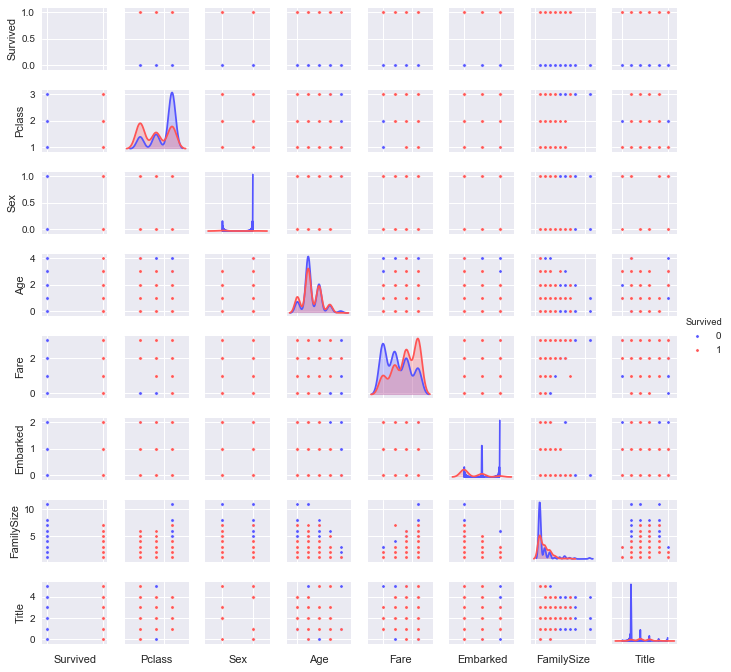

In [9]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Fare', u'Embarked', u'FamilySize', u'Title']], hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

### Creating models

In [10]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)

class SklearnHelper(object):
    
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_
    
    def get_confidence_score(self, x, y):
        return round(self.clf.score(x, y)*100, 2)

In [11]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [12]:
# Parameters for different classifiers

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 595,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':595,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 595,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 595,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [13]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [14]:
# dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

In [15]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print('Training is complete !!!')

Training is complete !!!


In [16]:
predicted_result = pd.DataFrame(columns=['PassengerId', 'Survived'])
predicted_result['PassengerId'] = PassengerId

# Random Forest prediction
print(rf.get_confidence_score(x_train, y_train), '\n')
predicted_result['Survived'] = rf.predict(x_test)
predicted_result.to_csv('Output/random_forest.csv', index=False)

# Extra Trees prediction
print(et.get_confidence_score(x_train, y_train), '\n')
predicted_result['Survived'] = et.predict(x_test)
predicted_result.to_csv('Output/extra_trees.csv', index=False)

# Ada Boost
print(ada.get_confidence_score(x_train, y_train), '\n')
predicted_result['Survived'] = ada.predict(x_test)
predicted_result.to_csv('Output/ada_boost.csv', index=False)

# Gradient Boost
print(gb.get_confidence_score(x_train, y_train), '\n')
predicted_result['Survived'] = gb.predict(x_test)
predicted_result.to_csv('Output/gradient_boost.csv', index=False)

# Support Vector Machine
print(svc.get_confidence_score(x_train, y_train), '\n')
predicted_result['Survived'] = svc.predict(x_test)
predicted_result.to_csv('Output/svm.csv', index=False)

84.85 

84.85 

81.37 

87.99 

81.93 



In [17]:
rf_features = rf.feature_importances(x_train, y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train, y_train)

In [18]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({'features': cols,
                                 'Random Forest feature importances': rf_features,
                                 'Extra Trees feature importances': et_features,
                                 'AdaBoost feature importances': ada_features,
                                 'Gradient Boost feature importances': gb_features
                                 })


In [19]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale = 'Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [20]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.030252,0.166306,0.128541,0.169555,Pclass,0.123664
1,0.319328,0.424904,0.050499,0.233599,Sex,0.257082
2,0.011765,0.034630,0.147643,0.040315,Age,0.058588
3,0.035294,0.077826,0.160566,0.103424,Fare,0.094277
4,0.015126,0.032468,0.118115,0.033904,Embarked,0.049903
5,0.065546,0.059305,0.179188,0.097015,FamilySize,0.100264
6,0.008403,0.030967,0.070277,0.022618,IsAlone,0.033066
7,0.514286,0.173594,0.145172,0.299570,Title,0.283155


In [21]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

### First-level output as new features

In [22]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [23]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [24]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

### Second level learning model via XGBoost

In [25]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)
print(round(gbm.score(x_train, y_train))*100, 2)

100.0 2


In [26]:
# Generate Submission File 

StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("Output/StackingSubmission.csv", index=False)

